### Case Study number of blogposts

See: 
http://archive.ics.uci.edu/ml/datasets/BlogFeedback

Status: Under construction. The likelihood of the LR and the mixture model needs checking.


As suggested in the [paper](http://www.cs.bme.hu/~buza/pdfs/gfkl2012_blogs.pdf) and acomaning [talk](http://archive.ics.uci.edu/ml/datasets/BlogFeedback), we use only the base features

#### Results Hits@10 mean and stdderr


##### 20,5 with only base features
LR   5.483   0.181799  #<--- In the paper they had 5.450 +- 1.322 (whatever +- is)

Poisson 5.966 0.1763

ZI Poisson 6.0 0.15

In [3]:
BLOG = True
import os
if not os.path.isfile('blogdata/BlogFeedback.zip'):
    !mkdir blogdata
    print("Installing wget")
    !pip install wget
    import wget
    print("Downloading file")
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip', 'blogdata/BlogFeedback.zip')
    print("Unzipping content")
    !unzip blogdata/BlogFeedback.zip -d blogdata
else:
    print("File exists")

File exists


In [43]:
import os
### dear data
DEER = True
# if not os.path.isfile('deerdata/DVC.tgz'):
#     !mkdir deerdata
#     print("Installing wget")
#     !pip install wget
#     import wget
#     print("Downloading file")
#     wget.download('https://zenodo.org/record/17179/files/DVC.tgz?download=1', 'deerdata/DVC.tgz')
#     print("Unpacking content")
#     !tar -C deerdata/ -xvf deerdata/DVC.tgz 
# else:
#     print("File exists")


Installing wget
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Unpacking content
README.txt
analysis/DVC.rda
analysis/smooth_models.R
analysis/parametric_models.R
analysis/inference.R
analysis/helpers.R
analysis/results.Rnw
analysis/appendix.Rnw
analysis/setup.R
data/karten/DEU_adm0.Rda
data/karten/DEU_adm1.Rda
preproc/cars.rda
analysis/smooth_cars.R


In [4]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


In [6]:
BLOG = True
USE_BASE = True #Use only the Basic features (successfully in paper)
if BLOG:
    # Loading to the data
    d = np.loadtxt("blogdata/blogData_train.csv", delimiter=',', dtype=np.float32)
    if USE_BASE:
      Xu = d[:,0:63]
    else:
      Xu = d[:,0:279]

    y = d[:,280]
    d.shape, Xu.shape, y.shape

In [7]:
Xmean = np.mean(Xu,axis=0)
Xsd = np.std(Xu,axis=0)
X = (Xu-Xmean)/(Xsd+1e-10)
X = np.clip(X,-5,5)
np.max(X),np.min(X)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
from scipy.stats import spearmanr
def check_performance(model_mean):
  files = [f for f in os.listdir('blogdata/') if f.startswith('blogData_test')]
  hits_at10 = np.zeros(len(files))
  cors = np.zeros(len(files))
  for i,f in enumerate(files):
      d = np.loadtxt("blogdata/"+f, delimiter=',', dtype=np.float32)
      #print("{}".format(i))
      Xtu = d[:,0:X.shape[1]]
      yt = d[:,280]
      Xt = (Xtu-Xmean) / (Xsd+1e-10)
      d.shape, Xtu.shape, yt.shape
      y_pred = model_mean.predict(Xt).flatten()
      idx_true = np.argsort(yt)[-10:]
      idx_pred = np.argsort(y_pred)[-10:] #The 10 higest
      hits_at10[i]=len(np.intersect1d(idx_true, idx_pred))
      cors[i] = spearmanr(yt, y_pred)[0]
  return (np.mean(hits_at10), np.std(hits_at10)/np.sqrt(len(files)),np.mean(cors), np.std(cors)/np.sqrt(len(files)))

In [9]:
spearmanr([1,2,2], [1,2,4])[0]

0.8660254037844387

### Definition of a base model 

In [369]:
## Definition of the base model
from tensorflow.keras.regularizers import l2
# def make_base(inputs):
#     rate = tf.keras.layers.Dense(20,  kernel_regularizer=l2(1e-2),  bias_regularizer=l2(1e-4),activation='sigmoid')(inputs)
#     return tf.keras.layers.Dense(5,  kernel_regularizer=l2(1e-2),  bias_regularizer=l2(1e-4),activation='sigmoid')(rate)

def make_base(inputs):
    return  tf.keras.layers.Dense(3,  kernel_regularizer=l2(1e-2),  bias_regularizer=l2(1e-4),activation='sigmoid')(inputs)
    

epochs = 30



### Fitting Normal

In [17]:
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
out = tf.keras.layers.Dense(1)(make_base(inputs))
model = tf.keras.models.Model(inputs=inputs, outputs=out)
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
hist = model.fit(X_tr, y_tr, epochs=epochs, verbose=1, validation_data=(X_te, y_te))

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 2s 32us/sample - loss: 1402.3710 - val_loss: 1748.9285
Epoch 2/30
47157/47157 [==============================] - 1s 28us/sample - loss: 1374.7981 - val_loss: 1723.6521
Epoch 3/30
47157/47157 [==============================] - 1s 28us/sample - loss: 1352.1492 - val_loss: 1701.4781
Epoch 4/30
47157/47157 [==============================] - 1s 27us/sample - loss: 1331.9881 - val_loss: 1681.3842
Epoch 5/30
47157/47157 [==============================] - 1s 28us/sample - loss: 1313.8318 - val_loss: 1662.9327
Epoch 6/30
47157/47157 [==============================] - 1s 28us/sample - loss: 1297.5361 - val_loss: 1647.1419
Epoch 7/30
47157/47157 [==============================] - 1s 31us/sample - loss: 1282.8582 - val_loss: 1631.9571
Epoch 8/30
47157/47157 [==============================] - 1s 27us/sample - loss: 1269.5947 - val_loss: 1618.6016
Epoch 9/30
47157/47157 [=======================

In [18]:
y_hat_tr = model.predict(X_tr) #Trainingset
y_hat_te = model.predict(X_te) #Testset

In [19]:
sigma_hat_2 = np.var(y_hat_tr.flatten() - y_tr) #We estimate sigma from the training set

$$
   NLL/n =  0.5 \cdot \ln (2 \cdot \pi \cdot \sigma^2) + 0.5 * \frac{1}{n} \sum \frac{(y_i-\hat{y_i})^2}{ \sigma^2 }
$$

,hits@10 [mean],hits@10 [std],loss_val [mean],loss_val [std],rank_corr [mean],rank_corr [std]
normal,5.483333,0.18483,5.267406,-1,0.463492,0.010763


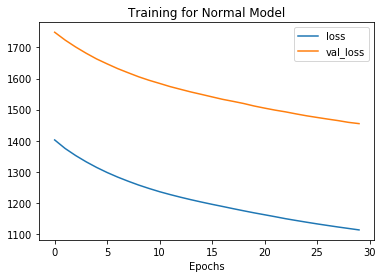

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.title('Training for Normal Model')
np.mean(hist.history['loss'])

d = check_performance(model)

dd =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_hat_te - y_te)**2)/sigma_hat_2

import pandas as pd
df = pd.DataFrame(
    {'hits@10 [mean]' : d[0], 'hits@10 [std]' : d[1],
    'rank_corr [mean]' : d[2], 'rank_corr [std]' : d[3],
    'loss_val [mean]' : dd, 'loss_val [std]' : -1},
    index=['normal'])
df

In [21]:
np.mean(hist.history['val_loss'][-10:])

1478.474523507475

### Fitting a poisson

In [15]:
def negloglik(y_true, y_hat):
  return -y_hat.log_prob(y_true)

In [16]:
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
rate = tf.keras.layers.Dense(1, 
                                 activation=tf.exp, 
                                 bias_initializer='zeros', 
                                 kernel_initializer='zeros')(make_base(inputs))

p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)

In [17]:
hist = model.fit(X_tr, y_tr, epochs=epochs, verbose=1, validation_data=(X_te, y_te))

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 2s 39us/sample - loss: 17.1105 - val_loss: 13.0660
Epoch 2/30
47157/47157 [==============================] - 2s 34us/sample - loss: 10.3284 - val_loss: 10.3721
Epoch 3/30
47157/47157 [==============================] - 1s 29us/sample - loss: 8.9881 - val_loss: 9.5987
Epoch 4/30
47157/47157 [==============================] - 1s 29us/sample - loss: 8.3664 - val_loss: 9.1287
Epoch 5/30
47157/47157 [==============================] - 1s 29us/sample - loss: 7.9386 - val_loss: 8.4994
Epoch 6/30
47157/47157 [==============================] - 1s 28us/sample - loss: 7.2443 - val_loss: 8.1440
Epoch 7/30
47157/47157 [==============================] - 1s 27us/sample - loss: 6.9343 - val_loss: 7.9682
Epoch 8/30
47157/47157 [==============================] - 1s 27us/sample - loss: 6.7483 - val_loss: 7.8526
Epoch 9/30
47157/47157 [==============================] - 1s 28us/sample - loss: 6.6451 - v

,hits@10 [mean],hits@10 [std],loss_val [mean],loss_val [std],rank_corr [mean],rank_corr [std]
normal,5.516667,0.162432,5.269432,-1.000000,0.461417,0.011046
Poisson,5.716667,0.179647,7.476394,0.056384,0.495745,0.010436


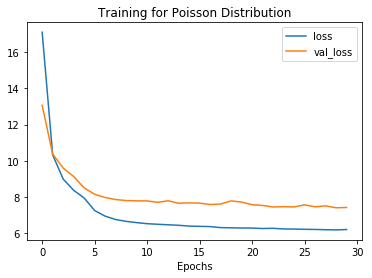

In [18]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.title('Training for Poisson Distribution')
np.mean(hist.history['loss'])

d = check_performance(model_mean)

if (epochs > 10):
    dd = np.mean(hist.history['val_loss'][-10:])
    ddd = np.std(hist.history['val_loss'][-10:])
else:
    dd = ddd = -1.
import pandas as pd
df1 = pd.DataFrame(
    {'hits@10 [mean]' : d[0], 'hits@10 [std]' : d[1],
     'rank_corr [mean]' : d[2], 'rank_corr [std]' : d[3],
    'loss_val [mean]' : dd, 'loss_val [std]' : ddd},
    index=['Poisson'])
df = df.append(df1)
df

### Fitting ZIP

In [19]:
def zero_inf(out): 
    rate = tf.math.exp(out[:,0]) #A 
    #rate = tf.math.softplus(out[:,0]) #A 
    s = tf.math.sigmoid(out[:,1:]) #B  
    probs = tf.concat([s, 1-s], axis=1) #C 
    print(np.min(rate), " ", np.max(rate), " ", np.min(s), np.max(s),"  ",np.min(out[:,1:]), np.max(out[:,1:]))
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
            tfd.Deterministic(loc=tf.zeros_like(rate)), #E
            tfd.Poisson(rate=rate), #F 
        ])

In [13]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))

In [21]:
#   One pah for all
# from tensorflow.keras.regularizers import l2
# inputs = tf.keras.layers.Input(shape=(X.shape[1],))
# rate = tf.keras.layers.Dense(2,  kernel_regularizer=l2(0.01))(make_base(inputs))

# p_y = tfp.layers.DistributionLambda(zero_inf)(rate) 
# model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
# model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
# model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
# model.summary()

In [219]:
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
mean = tf.keras.layers.Dense(1,  kernel_regularizer=l2(0.01))(make_base(inputs))
z = tf.keras.layers.Dense(1,  kernel_regularizer=l2(0.01))(make_base(inputs))
tt = tf.concat([mean, z], axis=1)
p_y = tfp.layers.DistributionLambda(zero_inf)(tt) 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
model.summary()

NameError: name 'zero_inf' is not defined

In [220]:
hist = model.fit(X_tr, y_tr, epochs=epochs, verbose=1, validation_data=(X_te, y_te))

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 2s 38us/sample - loss: 1.3748 - val_loss: 1.4421
Epoch 2/30
47157/47157 [==============================] - 2s 39us/sample - loss: 1.3744 - val_loss: 1.4414
Epoch 3/30
47157/47157 [==============================] - 2s 41us/sample - loss: 1.3741 - val_loss: 1.4414
Epoch 4/30
47157/47157 [==============================] - 2s 38us/sample - loss: 1.3737 - val_loss: 1.4406
Epoch 5/30
47157/47157 [==============================] - 2s 40us/sample - loss: 1.3736 - val_loss: 1.4404
Epoch 6/30
47157/47157 [==============================] - 2s 41us/sample - loss: 1.3734 - val_loss: 1.4400
Epoch 7/30
47157/47157 [==============================] - 2s 39us/sample - loss: 1.3732 - val_loss: 1.4398
Epoch 8/30
47157/47157 [==============================] - 2s 39us/sample - loss: 1.3731 - val_loss: 1.4397
Epoch 9/30
47157/47157 [==============================] - 2s 40us/sample - loss: 1.3730 - val_l

,hits@10 [mean],hits@10 [std],loss_val [mean],loss_val [std],rank_corr [mean],rank_corr [std]
normal,5.483333,0.184830,5.267406,-1.000000,0.463492,0.010763
Mixture,5.016667,0.165817,1478.474524,16.046293,0.522210,0.009667
Mixture,5.016667,0.165817,1351.460546,8.740586,0.522210,0.009667
Mixture,5.000000,0.179505,-2.346331,0.159453,0.527996,0.009331
Mixture,5.000000,0.179505,-2.346331,0.159453,0.527996,0.009331
Mixture,5.000000,0.164992,-3.172075,0.382729,0.524741,0.009545
Mixture,5.000000,0.164992,-3.172075,0.382729,0.524741,0.009545
Mixture,4.933333,0.159629,-2.300916,0.554357,0.522343,0.009680
Mixture,5.033333,0.168270,-2.747056,0.547644,0.520435,0.009516
Mixture,5.033333,0.168270,NaN,NaN,0.520435,0.009516


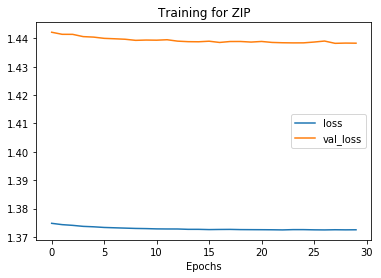

In [221]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.title('Training for ZIP')
np.mean(hist.history['loss'])

d = check_performance(model_mean)
if (epochs > 10):
    dd = np.mean(hist.history['val_loss'][-10:])
    ddd = np.std(hist.history['val_loss'][-10:])
else:
    dd = ddd = -1.
import pandas as pd
df1 = pd.DataFrame(
    {'hits@10 [mean]' : d[0], 'hits@10 [std]' : d[1],
     'rank_corr [mean]' : d[2], 'rank_corr [std]' : d[3],
    'loss_val [mean]' : dd, 'loss_val [std]' : ddd},
    index=['ZIP'])
df = df.append(df1)
df

### Definition of a Mixture Model

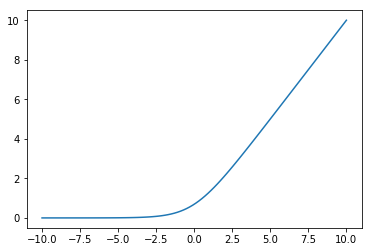

In [222]:
xv = np.linspace(-10,10,100)
plt.plot(xv,tf.nn.softplus(xv))

In [451]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
#See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution

def mixture_logistic(out, num=3, debug=True): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = tf.nn.softplus(un_scale)
    
    if (debug):
        print('location', loc,' scale ',scale, 'logits ', logits, ' ', tf.nn.softmax(logits))
        #print('location', loc.numpy(),' scale ',scale.numpy(), 'logits ', logits.numpy(), ' ', tf.nn.softmax(logits).numpy())
#     discretized_logistic_dist=tfd.TransformedDistribution(
#         distribution=tfd.Logistic(loc=loc, scale=scale),
#         bijector=tfb.AffineScalar(shift=-0.5))
    
    #print("mix_logi ", np.min(logits), " ", np.max(logits), " ", np.min(scale), np.max(scale),"  ",np.min(loc), np.max(loc))
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=tf.nn.softmax(logits)), #logits will be normalized to one
        #components_distribution=tfd.Logistic(loc=loc, scale=scale))
        #components_distribution=tfd.Normal(loc=loc, scale=scale))
        #components_distribution=tfd.Gamma(concentration=loc, rate=scale))
        components_distribution=tfd.Poisson(rate=scale))
    
    
    return mixture_dist

In [452]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
#See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution
# def mixture_logistic(out, bits=8, num=3): 
#     loc, un_scale, logits = tf.split(out,
#                                      num_or_size_splits=num,
#                                      axis=-1)
#     scale = tf.nn.softplus(un_scale)
#     discretized_logistic_dist = tfd.QuantizedDistribution(
#         #distribution=tfd.Logistic(loc=loc, scale=scale),
#         tfd.TransformedDistribution(
#         distribution=tfd.Logistic(loc=loc, scale=scale),
#         bijector=tfb.AffineScalar(shift=-0.5)),
#     low=0.,
#     high=2**bits - 1.)
#     mixture_dist = tfd.MixtureSameFamily(
#         mixture_distribution=tfd.Categorical(logits=logits), #logits will be normalized to one
#         components_distribution=discretized_logistic_dist)
#     return mixture_dist

In [453]:
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X.shape[1],))

loc1    = tf.keras.layers.Dense(2,  kernel_regularizer=l2(0.01))(make_base(inputs))
scales1 = tf.keras.layers.Dense(2,  kernel_regularizer=l2(0.01))(make_base(inputs))
logits  = tf.keras.layers.Dense(2,  kernel_regularizer=l2(0.01))(make_base(inputs))

tt = tf.concat([loc1, scales1, logits], axis=1)
p_y = tfp.layers.DistributionLambda(mixture_logistic)(tt) 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
#model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
model_tt = tf.keras.models.Model(inputs=inputs, outputs=tt)
model.compile(optimizer=tf.optimizers.Adam(0.000001), loss=negloglik2)
model.summary()


location Tensor("distribution_lambda_64/split:0", shape=(None, 2), dtype=float32)  scale  Tensor("distribution_lambda_64/Softplus:0", shape=(None, 2), dtype=float32) logits  Tensor("distribution_lambda_64/split:2", shape=(None, 2), dtype=float32)   Tensor("distribution_lambda_64/Softmax:0", shape=(None, 2), dtype=float32)
Model: "model_124"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           [(None, 63)]         0                                            
__________________________________________________________________________________________________
dense_400 (Dense)               (None, 3)            192         input_67[0][0]                   
__________________________________________________________________________________________________
dense_402 (Dense)               (None, 3)            192       

In [448]:
optimizer=tf.optimizers.RMSprop(learning_rate=0.05)
loss_values = np.zeros((1000))
for e in range(2):
    with tf.GradientTape() as tape:
        X = X_tr[0:2]
        y_true = y_tr[0:2]
        print(model_tt(X))
        y_hat = model(X)
        print(y_hat.mean())
        print(' Log probs ', y_hat.log_prob(y_true))
        print(' Y_true ', y_true)
        loss_value = -tf.reduce_mean(y_hat.log_prob(y_true))
        #print(loss_value)
        loss_values[e] = loss_value
        grads = tape.gradient(loss_value, model.trainable_weights)
        weights =  model.trainable_weights       
        optimizer.apply_gradients(zip(grads,weights))

tf.Tensor(
[[ 0.3613078  -0.37646288  0.1307937  -0.12151533 -0.1597456  -0.36252812]
 [ 0.5264889   0.1371901   0.23000574 -0.28650212 -0.28689238 -0.17613053]], shape=(2, 6), dtype=float32)
location tf.Tensor(
[[3.535205  2.7862844]
 [3.7929776 3.247046 ]], shape=(2, 2), dtype=float32)  scale  tf.Tensor(
[[3.2397325 2.9855773]
 [3.3586073 2.8508854]], shape=(2, 2), dtype=float32) logits  tf.Tensor(
[[-0.1597456  -0.36252812]
 [-0.28689238 -0.17613053]], shape=(2, 2), dtype=float32)   tf.Tensor(
[[0.5505226  0.44947737]
 [0.47233784 0.5276622 ]], shape=(2, 2), dtype=float32)
tf.Tensor([1.0202057 1.134412 ], shape=(2,), dtype=float32)
 Log probs  tf.Tensor([-inf -inf], shape=(2,), dtype=float32)
 Y_true  [0. 0.]
tf.Tensor(
[[nan nan nan nan nan nan]
 [nan nan nan nan nan nan]], shape=(2, 6), dtype=float32)
location tf.Tensor(
[[nan nan]
 [nan nan]], shape=(2, 2), dtype=float32)  scale  tf.Tensor(
[[nan nan]
 [nan nan]], shape=(2, 2), dtype=float32) logits  tf.Tensor(
[[nan nan]
 [nan n

In [454]:
hist = model.fit(X_tr, y_tr, epochs=30, verbose=1, validation_data=(X_te, y_te))

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 2s 45us/sample - loss: 27.5788 - val_loss: 29.5730
Epoch 2/30
47157/47157 [==============================] - 2s 39us/sample - loss: 27.5385 - val_loss: 29.5321
Epoch 3/30
47157/47157 [==============================] - 2s 39us/sample - loss: 27.4967 - val_loss: 29.4903
Epoch 4/30
47157/47157 [==============================] - 2s 38us/sample - loss: 27.4547 - val_loss: 29.4491
Epoch 5/30
47157/47157 [==============================] - 2s 38us/sample - loss: 27.4123 - val_loss: 29.4066
Epoch 6/30
47157/47157 [==============================] - 2s 39us/sample - loss: 27.3687 - val_loss: 29.3631
Epoch 7/30
47157/47157 [==============================] - 2s 42us/sample - loss: 27.3247 - val_loss: 29.3199
Epoch 8/30
47157/47157 [==============================] - 2s 39us/sample - loss: 27.2799 - val_loss: 29.2756
Epoch 9/30
47157/47157 [==============================] - 2s 40us/sample - loss

,hits@10 [mean],hits@10 [std],loss_val [mean],loss_val [std],rank_corr [mean],rank_corr [std]
normal,5.483333,0.184830,5.267406,-1.000000,0.463492,0.010763
Mixture,5.016667,0.165817,1478.474524,16.046293,0.522210,0.009667
Mixture,5.016667,0.165817,1351.460546,8.740586,0.522210,0.009667
Mixture,5.000000,0.179505,-2.346331,0.159453,0.527996,0.009331
Mixture,5.000000,0.179505,-2.346331,0.159453,0.527996,0.009331
Mixture,5.000000,0.164992,-3.172075,0.382729,0.524741,0.009545
Mixture,5.000000,0.164992,-3.172075,0.382729,0.524741,0.009545
Mixture,4.933333,0.159629,-2.300916,0.554357,0.522343,0.009680
Mixture,5.033333,0.168270,-2.747056,0.547644,0.520435,0.009516
Mixture,5.033333,0.168270,NaN,NaN,0.520435,0.009516


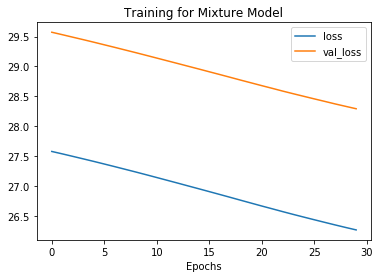

In [455]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.title('Training for Mixture Model')
np.mean(hist.history['loss'])

d = check_performance(model_mean)
if (epochs > 10):
    dd = np.mean(hist.history['val_loss'][-10:])
    ddd = np.std(hist.history['val_loss'][-10:])
else:
    dd = ddd = -1.
import pandas as pd
df1 = pd.DataFrame(
    {'hits@10 [mean]' : d[0], 'hits@10 [std]' : d[1],
     'rank_corr [mean]' : d[2], 'rank_corr [std]' : d[3],
    'loss_val [mean]' : dd, 'loss_val [std]' : ddd},
    index=['Mixture'])
df = df.append(df1)
df

location tf.Tensor([[ 0.9601004 -0.5157158]], shape=(1, 2), dtype=float32)  scale  tf.Tensor([[0.7996556 0.5170624]], shape=(1, 2), dtype=float32) logits  tf.Tensor([[-0.34259146  0.57654953]], shape=(1, 2), dtype=float32)   tf.Tensor([[0.28513297 0.71486706]], shape=(1, 2), dtype=float32)
0 Integral  0.6586851196289063  cdf [0.97525865]
location tf.Tensor([[ 0.49682492 -0.11266011]], shape=(1, 2), dtype=float32)  scale  tf.Tensor([[0.9184327  0.24378626]], shape=(1, 2), dtype=float32) logits  tf.Tensor([[-0.36713558  0.7224624 ]], shape=(1, 2), dtype=float32)   tf.Tensor([[0.251694   0.74830604]], shape=(1, 2), dtype=float32)
location tf.Tensor([[ 0.8233444  -0.32616305]], shape=(1, 2), dtype=float32)  scale  tf.Tensor([[0.8410945  0.39646864]], shape=(1, 2), dtype=float32) logits  tf.Tensor([[-0.41326463  0.76946855]], shape=(1, 2), dtype=float32)   tf.Tensor([[0.23456112 0.7654389 ]], shape=(1, 2), dtype=float32)
1 Integral  0.6294502563476563  cdf [0.98152494]
location tf.Tensor([[

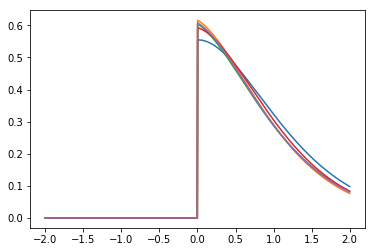

In [456]:
model_tt = tf.keras.models.Model(inputs=inputs, outputs=tt)
for i in range(5):
    res = model(X_tr[i:(i+1)])
    #res.mean()
    #res.stddev()
    #res.sample()
    steps=1000
    xvals = np.linspace(-2,2,num=steps)
    d = res.prob(xvals)
    #plt.plot(xvals, np.log(d))
    plt.plot(xvals, d)
    r = np.max(xvals) - np.min(xvals)
    print(i, 'Integral ', r/steps * np.sum(d), ' cdf', res.cdf(xvals[-1:]).numpy())
    mixture_logistic(model_tt(X_te[i:(i+1)]), debug=True)

tf.Tensor(0.39999998, shape=(), dtype=float32)
tf.Tensor(1.018, shape=(), dtype=float32)


0.9998999633789063

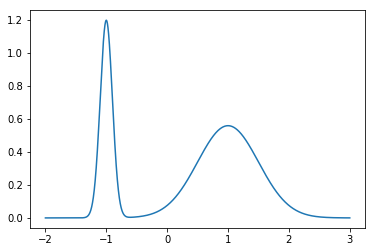

In [126]:
### Create a mixture of two scalar Gaussians:

gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.3, 0.7]),
    components_distribution=tfd.Normal(
      loc=[-1., 1],       # One for each component.
      scale=[0.1, 0.5]))  # And same here.

print(gm.mean())
# ==> 0.4

print(gm.variance())
# ==> 1.018

# Plot PDF.
x = np.linspace(-2., 3., int(1e4), dtype=np.float32)
import matplotlib.pyplot as plt
plt.plot(x, gm.prob(x).numpy());

#Newton for the really poor
steps=10000
xvals = np.linspace(-20,20,num=steps)
r = 20 - (-20)
d = gm.prob(xvals).numpy()
r/steps * np.sum(d)

In [119]:
r

40